In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganGenerator
morgan = GetMorganGenerator(radius=2)
fingerprinter = lambda smiles : np.stack([morgan.GetFingerprintAsNumPy(MolFromSmiles(smile)) for smile in smiles])

import torch
import torch.nn as nn
from models import MLP as MLP

%load_ext autoreload
%autoreload 2

## Data

In [2]:
data_path = '../../data/log_normalized/'

In [3]:
# Unimol Embeddings
train_X = np.load(data_path + 'train/unimol_embeddings.npy')
validation_X = np.load(data_path + 'validation/unimol_embeddings.npy')
test_X = np.load(data_path + 'test/unimol_embeddings.npy')

In [4]:
train_Y = pd.read_csv(data_path + 'train/y.csv')
validation_Y = pd.read_csv(data_path + 'validation/y.csv')
test_Y = pd.read_csv(data_path + 'test/y.csv')

train_STD = pd.read_csv(data_path + 'train/std.csv')
validation_STD = pd.read_csv(data_path + 'validation/std.csv')
test_STD = pd.read_csv(data_path + 'test/std.csv')

properties = train_Y.columns

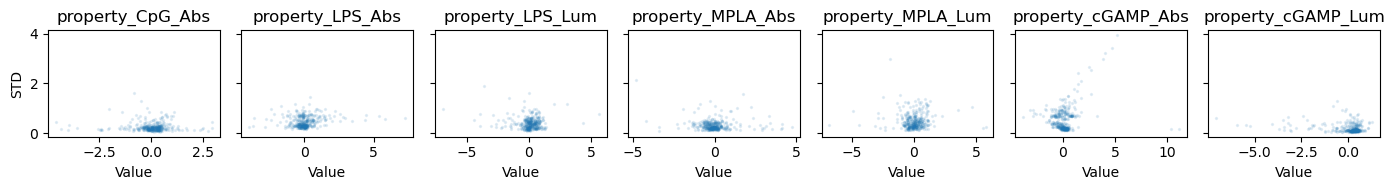

In [5]:
fig, axs = plt.subplots(1, 7, figsize=(14, 2), sharey=True)

for prop, ax in zip(properties, axs):

    ax.scatter(test_Y.loc[:, prop], test_STD.loc[:, prop], s=2, alpha=0.1)
    ax.set_title(prop)
    ax.set_xlabel('Value')

axs[0].set_ylabel('STD')
plt.tight_layout()

In [6]:
# Convert all to Tensors
train_X = torch.tensor(train_X, dtype=torch.float32).detach()
validation_X = torch.tensor(validation_X, dtype=torch.float32).detach()
test_X = torch.tensor(test_X, dtype=torch.float32).detach()

train_Y = torch.tensor(train_Y.to_numpy(), dtype=torch.float32).detach()
validation_Y = torch.tensor(validation_Y.to_numpy(), dtype=torch.float32).detach()
test_Y = torch.tensor(test_Y.to_numpy(), dtype=torch.float32).detach()

train_Var = torch.tensor(train_STD.to_numpy(), dtype=torch.float32).detach() ** 2
validation_Var = torch.tensor(validation_STD.to_numpy(), dtype=torch.float32).detach() ** 2
test_Var = torch.tensor(test_STD.to_numpy(), dtype=torch.float32).detach() ** 2

## MLP Model

## Train

In [7]:
mlp = MLP(in_features=train_X.shape[1], depth=3, width=256, dropout=0.5)

mlp.fit(
    train_X, train_Y, 
    test_X, test_Y
)

0.010465085506439209

## Visualization

In [16]:
test_predictions = pd.DataFrame(mlp(test_X).detach())
test_predictions.columns = properties

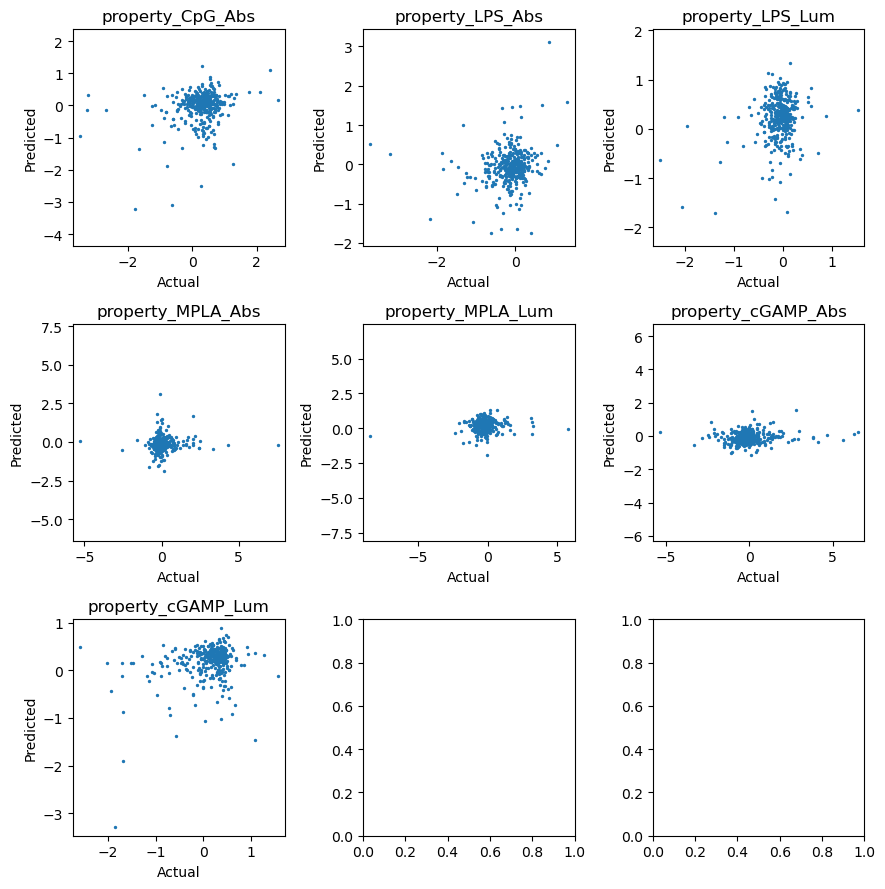

In [17]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flatten()

for i, property_label in enumerate(properties):

    ax = axs[i]

    ax.scatter(test_Y[:, i], test_predictions.iloc[:, i], s=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(property_label)
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()